In [2]:
import numpy as np
from matplotlib import pyplot as plt
from model import USV
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN
from stable_baselines3.dqn.policies import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env


final_path = np.load("data/first_optimal_path_with_yaw-2.npy")
final_path*=15


initial_positions = [(final_path[0][0], final_path[0][1], final_path[0][2])]
final_path = final_path[:,:2]

env = USV(
    v=0,
    dt=0.2,
    path_index=0,
    goal=final_path[-1],
    budget=20,
    initial_positions=initial_positions,
    final_paths=[final_path],
)

model = DQN.load("trained_models/dqn_communication_optimization_epsfrac08_steps300k_turtlebot_path_budget20_dronelab")

obs, _ = env.reset()
done = False
total_rewards = 0
ep_var = []
errors = []
traj_errors = [np.linalg.norm([env.car.x_true, env.car.y_true] - final_path[env.path_index])]
print("-------")
communicate_indices = []
variances = []
car_positions = [[env.car.x_true, env.car.y_true]]
observations = [np.array([env.car.x, env.car.y, env.car.v, env.car.psi, env.available_budget], dtype=np.float32)]
waypoint_deviations = 0
while not done:
    if np.linalg.norm([env.car.x, env.car.y] - final_path[env.path_index]) > 0.2*15:
        waypoint_deviations += 1
    if env.path_index <= 20:
        action = 0
    else:
        
        action, _states = model.predict(
            obs[:5], deterministic=True
        )  # Use the model to predict the action
    if action == 1:
        communicate_indices.append(env.path_index)

    traj_errors.append(np.linalg.norm([env.car.x_true, env.car.y_true] - final_path[env.path_index]))
    errors.append(
        np.linalg.norm(
            np.array([env.car.x, env.car.y]) - np.array([env.car.x_true, env.car.y_true])
        ))
    variances.append(np.linalg.norm(env.car.pf_var))
    obs, rewards, terminated, truncated, info = env.step_test(
        action
    )  # Take the action in the environment
    observations.append(obs[:5])
    car_positions.append([env.car.x_true, env.car.y_true])
    total_rewards += rewards
    done = truncated or terminated

-------


19


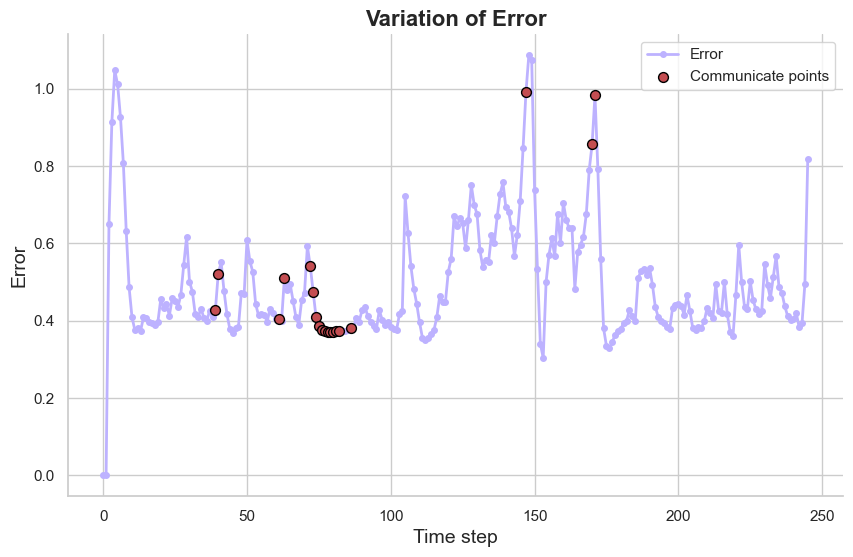

In [3]:
print(len(communicate_indices))
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(traj_errors, label="Error", linestyle='-', marker='o', markersize=4, linewidth=2, color='#BDB2FF')
plt.scatter(communicate_indices, [traj_errors[i] for i in communicate_indices], c='r', label="Communicate points", s=50, edgecolor='black', zorder=5)
plt.title("Variation of Error", fontsize=16, fontweight='bold')
plt.xlabel("Time step", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.legend()
sns.despine()
plt.show()

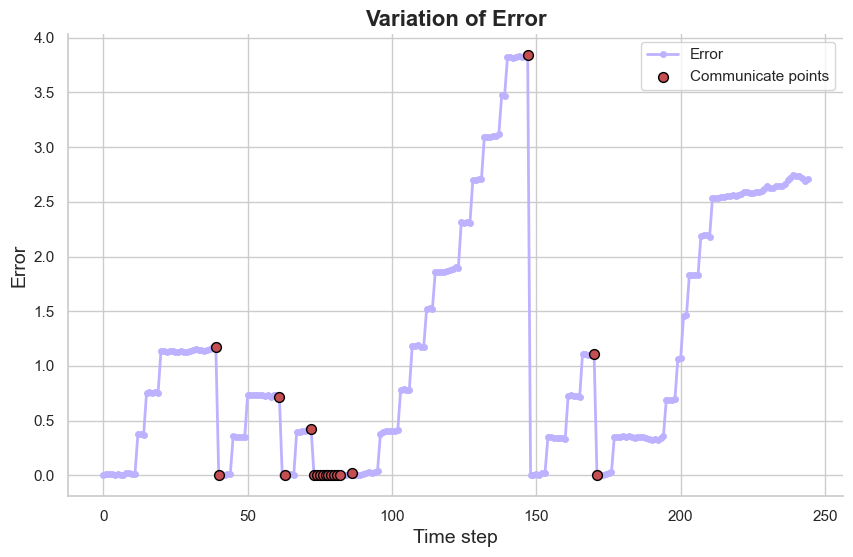

In [4]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(errors, label="Error", linestyle='-', marker='o', markersize=4, linewidth=2, color='#BDB2FF')
plt.scatter(communicate_indices, [errors[i] for i in communicate_indices], c='r', label="Communicate points", s=50, edgecolor='black', zorder=5)
plt.title("Variation of Error", fontsize=16, fontweight='bold')
plt.xlabel("Time step", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.legend()
sns.despine()
plt.show()

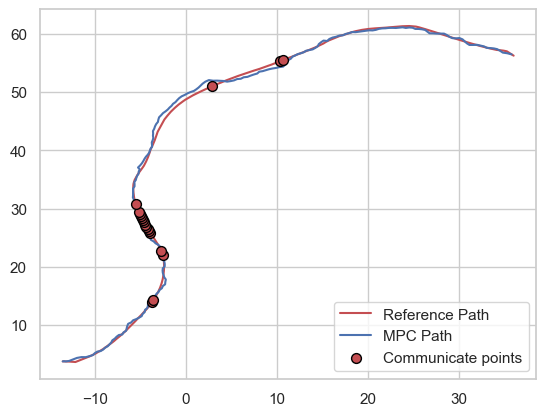

In [5]:
plt.plot(final_path[:, 0], final_path[:, 1], "r", label="Reference Path")
plt.plot(np.array(car_positions)[:, 0], np.array(car_positions)[:, 1], "b", label="MPC Path")
plt.scatter(final_path[communicate_indices, 0], final_path[communicate_indices, 1], c='r', label="Communicate points", s=50, edgecolor='black', zorder=5)
plt.legend()
plt.show()